# MIS 583 Assignment 5: YOLO Object Detection on PASCAL VOC

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 池品叡, B094020030.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

## How to Get Data

請先到共用雲端硬碟將檔案 `VOCdevkit_2007.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1jWpMbjxFl1JALOcwRMg3dl44UAURQ2XB/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `VOCdevkit_2007.zip` 

+ `VOC2007` : 包含了train/val的所有圖片
+ `VOC2007test` : 包含了test的所有圖片

其中`train`的圖片 3756 張，`val`的圖片 1255 張，`test` 的圖片 4950 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

# Import package

In [1]:
import os
import random

import cv2
import numpy as np

import csv

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate, test_evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import write_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [17]:
load_network_path = 'checkpoints/best_detector_SGD.pth' #'checkpoints/best_detector.pth' 
#load_network_path = None #'checkpoints/best_detector.pth' 

pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from checkpoints/best_detector_SGD.pth


In [5]:
learning_rate = 1e-5
num_epochs = 50
batch_size = 16

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [6]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 3756 train images


In [7]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [8]:
file_root_val = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_val = 'data/voc2007val.txt'

val_dataset = VocDetectorDataset(root_img_dir=file_root_val,dataset_file=annotation_file_val,train=False, S=S)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=0)
print('Loaded %d val images' % len(val_dataset))

Initializing dataset
Loaded 1255 val images


In [9]:
#print(type(train_dataset[0]))
data1 = train_dataset[0]
data2 = val_dataset[0]
print(len(data1)) # Img, Target Boxes, Target Classes, If there's Obj map(TRUE, FALSE)
print(len(data2))

4
4


## Set up training tools

In [10]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-4)

In [11]:
# 清除 cuda 快取
torch.cuda.empty_cache()

In [12]:
print(torch.__version__)
import torchvision
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cpu


In [13]:
for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate
    print(param_group['lr'])

1e-05


## Train detector

In [14]:
best_val_loss = np.inf
learning_rate = 1e-5
train_loss_list = []
val_loss_list= []
for epoch in range(num_epochs):
    net.train()
    
    
    # Update learning rate late in training
    #if epoch == 30 or epoch == 40:
    #    learning_rate /= 10.0
    #for param_group in optimizer.param_groups:
    #    param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    #print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        #t_loss = loss_dict['total_loss']
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        train_loss_list.append(loss_dict['total_loss'])
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the val data
    if (epoch + 1) % 5 == 0:
        val_aps = evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val)
        print(epoch, val_aps)
    val_loss = torch.zeros(0)
    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss += loss_dict['total_loss'].item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss / len(val_loader))
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best val loss: %.5f' % best_val_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))
        
    scheduler.step(val_loss)

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 1 / 50
Epoch [1/50], Iter [50/235], Loss: total=75.798, reg=5.277, containing_obj=1.387, no_obj=54.875, cls=14.260
Epoch [1/50], Iter [100/235], Loss: total=72.743, reg=5.166, containing_obj=1.355, no_obj=52.631, cls=13.592
Epoch [1/50], Iter [150/235], Loss: total=70.049, reg=5.052, containing_obj=1.316, no_obj=50.454, cls=13.227
Epoch [1/50], Iter [200/235], Loss: total=67.155, reg=4.884, containing_obj=1.245, no_obj=48.359, cls=12.665
Updating best val loss: 57.13199


Starting epoch 2 / 50
Epoch [2/50], Iter [50/235], Loss: total=51.782, reg=4.551, containing_obj=0.934, no_obj=35.796, cls=10.500
Epoch [2/50], Iter [100/235], Loss: total=50.143, reg=4.595, containing_obj=0.920, no_obj=34.069, cls=10.560
Epoch [2/50], Iter [150/235], Loss: total=48.223, reg=4.580, containing_obj=0.889, no_obj=32.439, cls=10.315
Epoch [2/50], Iter [200/235], Loss: total=46.365, reg=4.507, containing_obj=0.856, no_obj=30.938, cls=10.065
Updating best val loss: 39.07468


Starting epoch

100%|██████████| 1255/1255 [01:59<00:00, 10.47it/s]


---class aeroplane ap 2.296326407828233e-05---
---class bicycle ap 0.0002716018534110477---
---class bird ap 0.00021540751184741315---
---class boat ap 6.110881953037871e-05---
---class bottle ap 0.0---
---class bus ap 2.458663716270207e-05---
---class car ap 0.0016010764035516484---
---class cat ap 0.00019403402656169817---
---class chair ap 5.398854120758044e-05---
---class cow ap 0.0002900403328316711---
---class diningtable ap 7.267864410721553e-06---
---class dog ap 0.0003623965819836175---
---class horse ap 2.51807417686953e-05---
---class motorbike ap 0.0---
---class person ap 0.009047147369963392---
---class pottedplant ap 7.774236181295187e-06---
---class sheep ap 3.296612614992789e-05---
---class sofa ap 5.461615764407742e-06---
---class train ap 8.084178938450295e-05---
---class tvmonitor ap 5.968902020473334e-06---
---map 0.0006154906308904727---
4 [2.296326407828233e-05, 0.0002716018534110477, 0.00021540751184741315, 6.110881953037871e-05, 0.0, 2.458663716270207e-05, 0.001

100%|██████████| 1255/1255 [01:40<00:00, 12.52it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 5.715592135345222e-06---
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 9.394670090501988e-05---
---class cat ap 9.374619156096785e-06---
---class chair ap 0.0---
---class cow ap 3.587315253264457e-05---
---class diningtable ap 0.0---
---class dog ap 0.0---
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 0.014519114813661315---
---class pottedplant ap 1.9041815827557314e-05---
---class sheep ap 0.0---
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 1.1984803269454332e-05---
---map 0.0007347525748743716---
9 [0.0, 0.0, 0.0, 5.715592135345222e-06, 0.0, 0.0, 9.394670090501988e-05, 9.374619156096785e-06, 0.0, 3.587315253264457e-05, 0.0, 0.0, 0.0, 0.0, 0.014519114813661315, 1.9041815827557314e-05, 0.0, 0.0, 0.0, 1.1984803269454332e-05]
Updating best val loss: 10.10182


Starting epoch 11 / 50
Epoch [11/50], Iter [50/235], Loss: to

100%|██████████| 1255/1255 [01:05<00:00, 19.06it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0---
---class chair ap 0.0---
---class cow ap 0.0---
---class diningtable ap 0.0---
---class dog ap 0.0---
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 0.009198481050755216---
---class pottedplant ap 0.0---
---class sheep ap 0.0---
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.0---
---map 0.00045992405253776077---
14 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009198481050755216, 0.0, 0.0, 0.0, 0.0, 0.0]
Updating best val loss: 7.93461


Starting epoch 16 / 50
Epoch [16/50], Iter [50/235], Loss: total=7.622, reg=2.615, containing_obj=0.042, no_obj=2.047, cls=2.917
Epoch [16/50], Iter [100/235], Loss: total=7.733, reg=2.649, containing_obj=0.042, no_obj=2.029, cls=3.013
Epoch [16/50], Iter [150/235], Loss: total=7

KeyboardInterrupt: 

In [ ]:
evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val)

---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:24<00:00, 52.25it/s]

---class aeroplane ap 0.6495342035167719---
---class bicycle ap 0.5995116022900857---
---class bird ap 0.49538010766478285---
---class boat ap 0.43376342861206746---
---class bottle ap 0.23963014250389275---
---class bus ap 0.6864565598482422---
---class car ap 0.703436601353923---
---class cat ap 0.7709911751265506---
---class chair ap 0.33809238820662135---
---class cow ap 0.5387295349235165---
---class diningtable ap 0.3550931479004569---
---class dog ap 0.655615804496382---
---class horse ap 0.7098227984733275---
---class motorbike ap 0.5467164959273587---
---class person ap 0.5673300320180734---
---class pottedplant ap 0.29261978116521264---
---class sheep ap 0.43321949727408404---
---class sofa ap 0.4609778601352961---
---class train ap 0.8143345408584856---
---class tvmonitor ap 0.6189387201053136---
---map 0.5455097211200223---


[0.6495342035167719,
 0.5995116022900857,
 0.49538010766478285,
 0.43376342861206746,
 0.23963014250389275,
 0.6864565598482422,
 0.703436601353923,
 0.7709911751265506,
 0.33809238820662135,
 0.5387295349235165,
 0.3550931479004569,
 0.655615804496382,
 0.7098227984733275,
 0.5467164959273587,
 0.5673300320180734,
 0.29261978116521264,
 0.43321949727408404,
 0.4609778601352961,
 0.8143345408584856,
 0.6189387201053136]

# View example predictions

predicting...


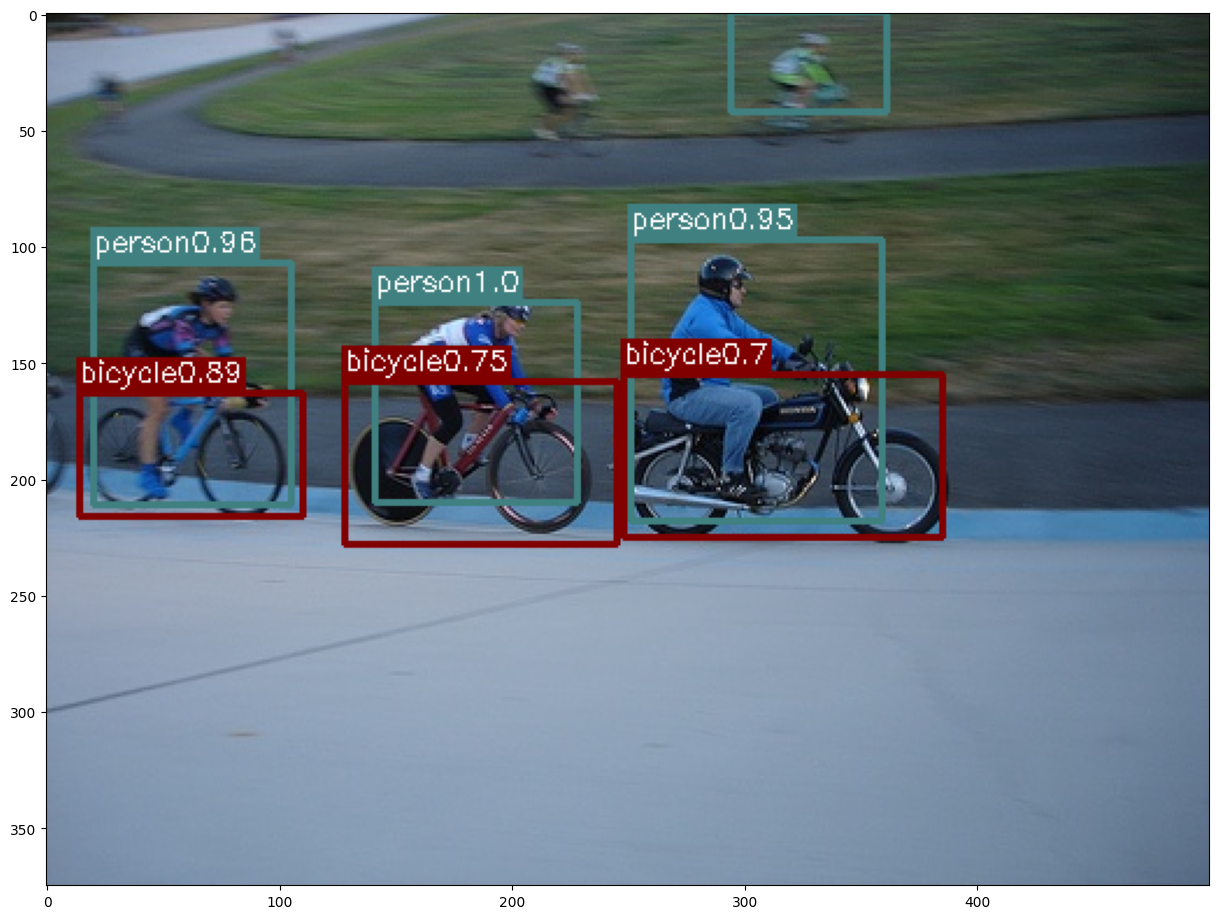

In [39]:
net.eval()

# select random image from val set
image_name = random.choice(val_dataset.fnames)
image = cv2.imread(os.path.join(file_root_val, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_val)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


# Kaggle submission (85%)

### Predict Result

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [ ]:
root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
file_test = 'data/voc2007test.txt'

By using the test_evaluate function, you will obtain predictions for each image.

In [ ]:
preds_submission = test_evaluate(net, test_dataset_file=file_test, img_root=root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:42<00:00, 48.36it/s]


The write_csv function will use preds_submission to write into a CSV file called 'result.csv'.

In [ ]:
write_csv(preds_submission)

# Report (15%)
In your report, please include:

a. A brief discussion on your implementation.

b. Report the best train and validation accuracy in all of your experiments and discuss
any strategies or tricks you’ve employed.

c. Report the results for extra credits and also provide a discussion, if any.

# Extra Credit (15%)

• Pick a fun video like [**this one**](https://www.youtube.com/watch?v=xZGahvrep3o), run your detector on it (a subset of frames would be
OK), and produce a video showing your results.

• Try to replace the provided pre-trained network with a different one and train with
the YOLO loss on top to attempt to get better accuracy.

• Or any other methods that you try to improve the performance.

## Video Detection Implementation

### Process Video Into Images

In [ ]:
from os import curdir
from torchvision import transforms
from torch.autograd import Variable


cap = cv2.VideoCapture('data/demo2.mp4')
colors = [tuple(255 * np.random.rand(3))for i in range(20)]

# 設置影片的寬度和高度
width = int(cap.get(3))
height = int(cap.get(4))

# 設置FPS（每秒幾幀）
fps = 2

# 設置影片的保存路徑
output_path = os.path.join(curdir, "data", "output_frames_2")

# 計數器
frame_count = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    #print(len(frame))
    #for img in frame:
    #    print(img.shape)
    #assert 0
    #if  ret:
    #    #cv2.imshow('frame', frame)
    #    if cv2.waitKey(1) & 0xFF == ord('q'):
    #        break
    if not ret:
        break

    # 每秒保存一幀
    if frame_count % int(fps) == 0:
        # 保存圖像文件
        img_name = "frame_" + str(frame_count) + ".jpg"
        filename = os.path.join(output_path, img_name)
        cv2.imwrite(filename, frame)
    frame_count += 1

cap.release()
cv2.destroyAllWindows()




### Make Predictions

In [ ]:
import os
import glob
net.eval()

# 指定图像文件所在的文件夹路径
image_folder_path = os.path.join(os.curdir, "data", "output_frames_2")
output_video_path = os.path.join(os.curdir, "data", "video_puppy.avi")


# 获取文件夹中所有以 .jpg 结尾的文件
image_files = glob.glob(os.path.join(image_folder_path, '*.jpg'))

sorted_image_files = sorted(image_files, key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
img = cv2.imread(sorted_image_files[0])
height, width, _ = img.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 10
video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# 打印所有图像文件的名称
for i, image_file in enumerate(sorted_image_files):
    image_name = (os.path.basename(image_file))
    image = cv2.imread(os.path.join(image_folder_path, image_name))
    print(image_name)
    result = predict_image(net, image_name, root_img_directory=image_folder_path)
    for left_up, right_bottom, class_name, _, prob in result:
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name + str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                    color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
    video.write(image)

video.release()

frame_0.jpg
frame_2.jpg
frame_4.jpg
frame_5.jpg
frame_6.jpg
frame_8.jpg
frame_10.jpg
frame_12.jpg
frame_14.jpg
frame_15.jpg
frame_16.jpg
frame_18.jpg
frame_20.jpg
frame_22.jpg
frame_24.jpg
frame_25.jpg
frame_26.jpg
frame_28.jpg
frame_30.jpg
frame_32.jpg
frame_34.jpg
frame_35.jpg
frame_36.jpg
frame_38.jpg
frame_40.jpg
frame_42.jpg
frame_44.jpg
frame_45.jpg
frame_46.jpg
frame_48.jpg
frame_50.jpg
frame_52.jpg
frame_54.jpg
frame_55.jpg
frame_56.jpg
frame_58.jpg
frame_60.jpg
frame_62.jpg
frame_64.jpg
frame_65.jpg
frame_66.jpg
frame_68.jpg
frame_70.jpg
frame_72.jpg
frame_74.jpg
frame_75.jpg
frame_76.jpg
frame_78.jpg
frame_80.jpg
frame_82.jpg
frame_84.jpg
frame_85.jpg
frame_86.jpg
frame_88.jpg
frame_90.jpg
frame_92.jpg
frame_94.jpg
frame_95.jpg
frame_96.jpg
frame_98.jpg
frame_100.jpg
frame_102.jpg
frame_104.jpg
frame_105.jpg
frame_106.jpg
frame_108.jpg
frame_110.jpg
frame_112.jpg
frame_114.jpg
frame_115.jpg
frame_116.jpg
frame_118.jpg
frame_120.jpg
frame_122.jpg
frame_124.jpg
frame_125.jpg
fr